In [62]:
import numpy as np
import re

In [268]:
from pathlib import Path

import matplotlib.pyplot as plt
import cv2
import numpy as np
from collections import defaultdict
from PIL import Image
import torch
from torch.utils.data import Dataset


class PairedDatImageDataset(Dataset):
    def __init__(self, data_dir="data", transform=None, dat_dtype=np.float32):
        """
        Args:
            data_dir (str or Path): directory containing .dat and .jpg files
            transform (callable, optional): image transform
            dat_dtype: numpy dtype for .dat files
        """
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.dat_dtype = dat_dtype

        self.samples = self._index_files()

    def _index_files(self):
        grouped = defaultdict(dict)

        for file in (self.data_dir / "v2_train" / "v2_train").iterdir():
            if not file.is_file():
                continue

            if file.suffix not in {".dat", ".jpg"}:
                continue

            grouped[file.stem][file.suffix] = file

            # match = re.match(r"([a-z]+)([0-9]+)", 'foofo21', re.I)
            # if match:
            #     items = match.groups()
            # print(items)

        samples = []
        for key, files in grouped.items():
            if ".dat" in files and ".jpg" in files:
                samples.append({
                    "key": key,
                    "dat": files[".dat"],
                    "img": files[".jpg"],
                })
            else:
                print(f"File {file.stem} did not find a match")

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # load sudoku data from `.dat` file
        sudoku = np.loadtxt(sample["dat"], skiprows=2, dtype=np.int16)
        if sudoku.shape != (9, 9):
            raise ValueError(f"Invalid sudoku shape: {sudoku.shape}")
        # sudoku = np.fromfile(sample["dat"], dtype=self.dat_dtype)      
        sudoku = torch.from_numpy(sudoku).float() # convert to float32 tensor for MSELoss


        # load image
        img = cv2.imread(sample["img"]) # Image.open(sample["img"]).convert("RGB")
        # TODO: Check if resizing is the right option?
        # Resize to have same input size -> Might skew the images slightly
        img = cv2.resize(img, (640,480))
        # Turn to grayscale
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # uint8 → float32, normalize
        img = img.astype(np.float32) / 255.0

        # add channel dimension: (1, H, W)
        img = torch.from_numpy(img).unsqueeze(0)
        
        # optional extra transforms (must expect torch.Tensor)
        if self.transform:
            img = self.transform(img)

        return sudoku, img
    
    def show_image(self, img):
        # img: torch tensor (1, H, W)
        img = img.squeeze(0).cpu().numpy()
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        
        # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [269]:
dat = np.loadtxt("../data/v2_train/v2_train/image1087.dat", skiprows=2, dtype=np.int16) 


dat= torch.from_numpy(dat)
dat

tensor([[0, 0, 2, 0, 0, 9, 1, 0, 5],
        [0, 8, 0, 7, 0, 3, 9, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 2, 0],
        [0, 5, 0, 0, 4, 0, 0, 0, 0],
        [7, 0, 0, 9, 0, 8, 0, 0, 3],
        [0, 0, 0, 0, 1, 0, 0, 6, 0],
        [0, 4, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 8, 2, 0, 1, 0, 9, 0],
        [9, 0, 3, 8, 0, 0, 6, 0, 0]], dtype=torch.int16)

In [270]:
ds = PairedDatImageDataset(data_dir="../data/")

In [271]:
ds[1][0]

tensor([[9., 0., 3., 0., 0., 0., 0., 0., 2.],
        [0., 6., 0., 4., 9., 0., 1., 0., 3.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 9., 0., 0.],
        [3., 0., 1., 0., 0., 4., 0., 0., 0.],
        [0., 8., 0., 7., 0., 2., 4., 3., 0.],
        [1., 7., 8., 5., 0., 9., 3., 0., 0.],
        [0., 0., 0., 0., 0., 0., 7., 5., 9.],
        [0., 0., 0., 3., 6., 7., 0., 0., 0.]])

In [272]:
ds.samples

[{'key': 'image180',
  'dat': PosixPath('../data/v2_train/v2_train/image180.dat'),
  'img': PosixPath('../data/v2_train/v2_train/image180.jpg')},
 {'key': 'image13',
  'dat': PosixPath('../data/v2_train/v2_train/image13.dat'),
  'img': PosixPath('../data/v2_train/v2_train/image13.jpg')},
 {'key': 'image36',
  'dat': PosixPath('../data/v2_train/v2_train/image36.dat'),
  'img': PosixPath('../data/v2_train/v2_train/image36.jpg')},
 {'key': 'image28',
  'dat': PosixPath('../data/v2_train/v2_train/image28.dat'),
  'img': PosixPath('../data/v2_train/v2_train/image28.jpg')},
 {'key': 'image1022',
  'dat': PosixPath('../data/v2_train/v2_train/image1022.dat'),
  'img': PosixPath('../data/v2_train/v2_train/image1022.jpg')},
 {'key': 'image105',
  'dat': PosixPath('../data/v2_train/v2_train/image105.dat'),
  'img': PosixPath('../data/v2_train/v2_train/image105.jpg')},
 {'key': 'image22',
  'dat': PosixPath('../data/v2_train/v2_train/image22.dat'),
  'img': PosixPath('../data/v2_train/v2_train/ima

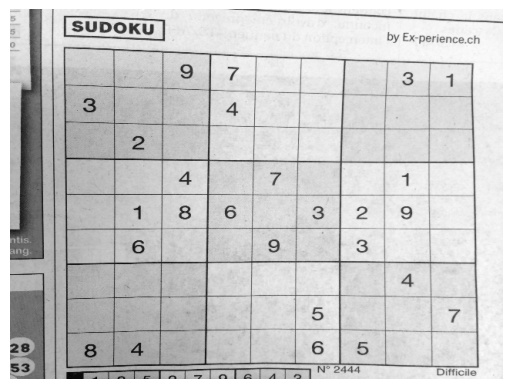

In [273]:
import matplotlib.pyplot as plt
# plt.imshow(ds[11][1])

ds.show_image(ds[11][1])

#### Imports

In [274]:
import matplotlib.pyplot as plt
import cv2
import imutils

### 1. Read in Image, Grayscale and Blur

In [275]:
ds[1][1].shape

torch.Size([1, 480, 640])

In [276]:
ds[51][1].shape

torch.Size([1, 480, 640])

In [277]:
# img = ds[9][1]
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

TODO: Different input sizes -> Requires fix

### 2. Apply filter and find edges for localization

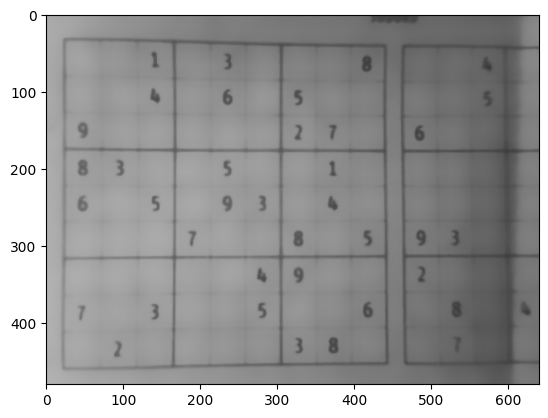

In [198]:
gray = ds[9][1]
bfilter = cv2.bilateralFilter(gray, 30, 20, 20) #Noise reduction
plt.imshow(cv2.cvtColor(bfilter, cv2.COLOR_BGR2RGB))

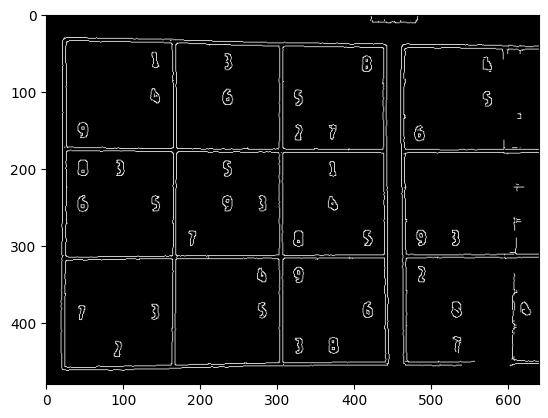

In [192]:
edged = cv2.Canny(bfilter, 30, 50) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

### 3. Find Contours and Apply Mask

In [193]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [194]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break


In [195]:
location

array([[[ 24,  30]],

       [[ 21, 461]],

       [[443, 455]],

       [[442,  40]]], dtype=int32)

In [196]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

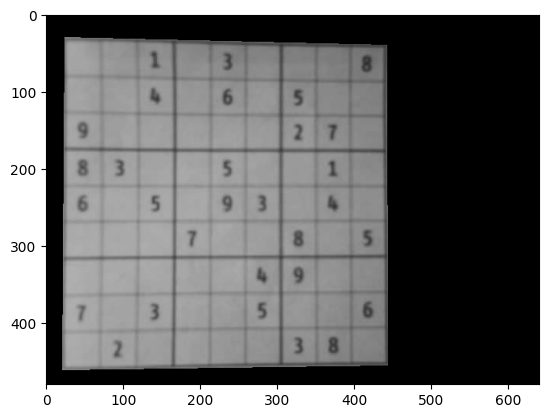

In [197]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [199]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

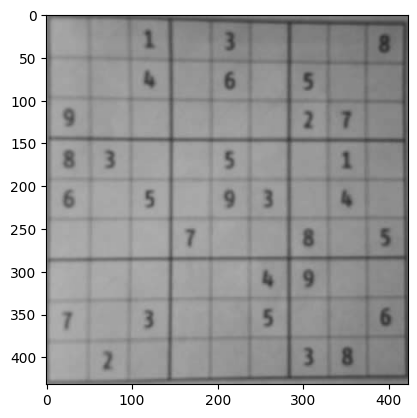

In [200]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

----

### Model

In [278]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [279]:
class CNN_Sudoku_Recog(nn.Module):
    def __init__(self):
        super().__init__()

        # ---- Feature extractor ----
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 240 x 320
            nn.ReLU(),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # 120 x 160
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 60 x 80
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 30 x 40
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 15 x 20
            nn.ReLU(),
        )

        # ---- Head ----
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 15 * 20, 9 * 9)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(-1, 9, 9)


In [280]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import MSELoss
from tqdm import tqdm

In [281]:
def train_model(
    model,
    dataset,
    *,
    batch_size=8,
    epochs=10,
    lr=1e-3,
    num_workers=4,
    device=None,
):
    """
    Train a PyTorch model on PairedDatImageDataset.
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    optimizer = Adam(model.parameters(), lr=lr)
    criterion = MSELoss()

    model.train()

    for epoch in range(epochs):
        epoch_loss = 0.0

        progress = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")

        print("-----------")
        for x in loader:
            print(x)
            break

        for dat, img in progress:
            # Move to device
            img = img.to(device)
            dat = dat.to(device)

            # Reshape target → (B, 9, 9)
            target = dat.view(-1, 9, 9)

            # Forward
            output = model(img)

            # Loss
            loss = criterion(output, target)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress.set_postfix(loss=loss.item())

        avg_loss = epoch_loss / len(loader)
        print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.6f}")

    return model


In [282]:
ds[0][1]

tensor([[[0.6275, 0.6275, 0.6275,  ..., 0.5216, 0.5216, 0.5216],
         [0.6275, 0.6275, 0.6275,  ..., 0.5216, 0.5216, 0.5216],
         [0.6235, 0.6235, 0.6235,  ..., 0.5216, 0.5216, 0.5216],
         ...,
         [0.6353, 0.6353, 0.6353,  ..., 0.4980, 0.4980, 0.4980],
         [0.6353, 0.6353, 0.6353,  ..., 0.4980, 0.4980, 0.4980],
         [0.6353, 0.6353, 0.6353,  ..., 0.4980, 0.4980, 0.4980]]])

In [283]:
# dataset = PairedDatImageDataset(
#     "data",
#     transform=transform,
# )

model = CNN_Sudoku_Recog()

trained_model = train_model(
    model,
    ds,
    epochs=5,
    batch_size=16,
    lr=1e-4,
)


Epoch 1/5:   0%|          | 0/10 [00:00<?, ?it/s]

-----------


[tensor([[[0., 0., 0.,  ..., 5., 0., 3.],
         [0., 0., 0.,  ..., 4., 0., 0.],
         [0., 0., 9.,  ..., 0., 8., 0.],
         ...,
         [0., 3., 0.,  ..., 9., 0., 0.],
         [0., 0., 7.,  ..., 0., 0., 0.],
         [9., 0., 4.,  ..., 0., 0., 0.]],

        [[5., 3., 0.,  ..., 0., 0., 8.],
         [0., 0., 0.,  ..., 9., 2., 5.],
         [0., 0., 0.,  ..., 1., 7., 0.],
         ...,
         [9., 8., 0.,  ..., 7., 0., 2.],
         [0., 7., 5.,  ..., 3., 8., 1.],
         [1., 0., 0.,  ..., 0., 0., 4.]],

        [[5., 3., 0.,  ..., 0., 0., 8.],
         [0., 0., 0.,  ..., 9., 2., 5.],
         [0., 0., 0.,  ..., 1., 7., 0.],
         ...,
         [9., 8., 0.,  ..., 7., 0., 2.],
         [0., 7., 5.,  ..., 3., 8., 1.],
         [1., 0., 0.,  ..., 0., 0., 4.]],

        ...,

        [[0., 0., 0.,  ..., 0., 8., 0.],
         [0., 9., 0.,  ..., 1., 0., 0.],
         [0., 0., 6.,  ..., 0., 7., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 3., 0.],
         [3., 7., 0.,

Epoch 1/5: 100%|██████████| 10/10 [00:03<00:00,  2.80it/s, loss=9.1]


Epoch 1 | Avg Loss: 10.320859


Epoch 2/5:   0%|          | 0/10 [00:00<?, ?it/s]

-----------
[tensor([[[0., 0., 0.,  ..., 5., 0., 3.],
         [0., 0., 0.,  ..., 4., 0., 0.],
         [0., 0., 9.,  ..., 0., 8., 0.],
         ...,
         [0., 3., 0.,  ..., 9., 0., 0.],
         [0., 0., 7.,  ..., 0., 0., 0.],
         [9., 0., 4.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [2., 0., 0.,  ..., 0., 4., 5.],
         [0., 7., 8.,  ..., 0., 0., 3.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [4., 2., 7.,  ..., 0., 6., 9.],
         [0., 0., 0.,  ..., 1., 8., 4.]],

        [[9., 0., 3.,  ..., 0., 0., 2.],
         [0., 6., 0.,  ..., 1., 0., 3.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 7., 8.,  ..., 3., 0., 0.],
         [0., 0., 0.,  ..., 7., 5., 9.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[7., 9., 5.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 3., 0.],
         [0., 8., 0.,  ..., 7., 0., 5.],
         ...,
         [8., 0., 4.,  ..., 0., 6., 0.],
         

Epoch 2/5: 100%|██████████| 10/10 [00:02<00:00,  3.34it/s, loss=8.44]


Epoch 2 | Avg Loss: 8.322620


Epoch 3/5:   0%|          | 0/10 [00:00<?, ?it/s]

-----------
[tensor([[[0., 0., 6.,  ..., 0., 0., 0.],
         [0., 4., 0.,  ..., 0., 0., 7.],
         [0., 7., 0.,  ..., 2., 1., 0.],
         ...,
         [0., 6., 3.,  ..., 0., 4., 0.],
         [1., 0., 0.,  ..., 0., 9., 0.],
         [0., 0., 0.,  ..., 6., 0., 0.]],

        [[7., 0., 0.,  ..., 0., 0., 0.],
         [0., 2., 1.,  ..., 0., 8., 0.],
         [0., 0., 0.,  ..., 0., 0., 6.],
         ...,
         [9., 0., 0.,  ..., 0., 0., 2.],
         [0., 0., 0.,  ..., 7., 0., 8.],
         [0., 6., 0.,  ..., 4., 0., 0.]],

        [[6., 0., 1.,  ..., 0., 0., 4.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 8., 9.,  ..., 0., 2., 0.],
         ...,
         [0., 5., 0.,  ..., 6., 0., 0.],
         [0., 0., 0.,  ..., 3., 4., 0.],
         [0., 0., 7.,  ..., 0., 8., 0.]],

        ...,

        [[0., 0., 4.,  ..., 0., 0., 0.],
         [0., 3., 0.,  ..., 0., 0., 0.],
         [8., 0., 0.,  ..., 1., 0., 0.],
         ...,
         [0., 0., 5.,  ..., 0., 0., 3.],
         

Epoch 3/5: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s, loss=8.5]


Epoch 3 | Avg Loss: 8.051025


Epoch 4/5:   0%|          | 0/10 [00:00<?, ?it/s]

-----------
[tensor([[[5., 3., 0.,  ..., 0., 0., 8.],
         [0., 0., 0.,  ..., 9., 2., 5.],
         [0., 0., 0.,  ..., 1., 7., 0.],
         ...,
         [9., 8., 0.,  ..., 7., 0., 2.],
         [0., 7., 5.,  ..., 3., 8., 1.],
         [1., 0., 0.,  ..., 0., 0., 4.]],

        [[0., 7., 1.,  ..., 0., 5., 0.],
         [0., 0., 0.,  ..., 7., 9., 0.],
         [0., 0., 9.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 3., 0., 0.],
         [0., 1., 5.,  ..., 0., 0., 0.],
         [0., 6., 0.,  ..., 9., 8., 0.]],

        [[9., 0., 3.,  ..., 0., 0., 2.],
         [0., 6., 0.,  ..., 1., 0., 3.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 7., 8.,  ..., 3., 0., 0.],
         [0., 0., 0.,  ..., 7., 5., 9.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[7., 0., 0.,  ..., 0., 0., 0.],
         [0., 2., 1.,  ..., 0., 8., 0.],
         [0., 0., 0.,  ..., 0., 0., 6.],
         ...,
         [9., 0., 0.,  ..., 0., 0., 2.],
         

Epoch 4/5: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s, loss=8.1]


Epoch 4 | Avg Loss: 8.035666


Epoch 5/5:   0%|          | 0/10 [00:00<?, ?it/s]

-----------
[tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [2., 0., 0.,  ..., 0., 4., 5.],
         [0., 7., 8.,  ..., 0., 0., 3.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [4., 2., 7.,  ..., 0., 6., 9.],
         [0., 0., 0.,  ..., 1., 8., 4.]],

        [[0., 0., 0.,  ..., 5., 0., 3.],
         [0., 0., 0.,  ..., 4., 0., 0.],
         [0., 0., 9.,  ..., 0., 8., 0.],
         ...,
         [0., 3., 0.,  ..., 9., 0., 0.],
         [0., 0., 7.,  ..., 0., 0., 0.],
         [9., 0., 4.,  ..., 0., 0., 0.]],

        [[0., 7., 1.,  ..., 0., 5., 0.],
         [0., 0., 0.,  ..., 7., 9., 0.],
         [0., 0., 9.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 3., 0., 0.],
         [0., 1., 5.,  ..., 0., 0., 0.],
         [0., 6., 0.,  ..., 9., 8., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 8., 0.],
         [0., 0., 7.,  ..., 0., 0., 4.],
         [0., 5., 0.,  ..., 1., 0., 0.],
         ...,
         [0., 0., 5.,  ..., 0., 2., 0.],
         

Epoch 5/5: 100%|██████████| 10/10 [00:03<00:00,  3.14it/s, loss=8.1]

Epoch 5 | Avg Loss: 8.001139


In [285]:
trained_model.eval()

CNN_Sudoku_Recog(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): ReLU()
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=76800, out_features=81, bias=True)
  )
)

In [286]:
def preprocess_image(image_path, device):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise RuntimeError(f"Failed to read image: {image_path}")

    img = cv2.resize(img, (640, 480))
    img = img.astype(np.float32) / 255.0

    img = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)
    # shape: (1, 1, 480, 640)

    return img.to(device)

In [287]:
@torch.no_grad()
def predict(model, image_path, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    model.eval()

    img = preprocess_image(image_path, device)

    output = model(img)   # shape: (1, 9, 9)
    output = output.squeeze(0)  # (9, 9)

    return output.cpu()

In [288]:
pred = predict(trained_model, "../data/v2_train/v2_train/image1087.jpg")
print(pred)
print(pred.shape)

tensor([[3.1157, 1.4925, 1.7589, 1.3376, 2.0827, 2.2227, 0.5781, 1.4573, 1.5864],
        [1.1848, 1.8297, 1.6706, 1.4542, 2.5070, 1.7743, 1.6839, 1.6771, 2.2168],
        [1.3451, 2.2983, 2.5311, 1.6437, 1.6816, 1.8102, 1.3344, 1.6791, 1.5572],
        [1.2259, 0.9486, 1.7345, 2.1484, 0.6656, 2.0924, 2.7434, 1.7056, 1.2700],
        [2.7663, 2.0348, 2.7442, 1.5518, 1.3289, 1.8544, 1.4939, 1.4716, 1.9753],
        [1.3507, 1.1962, 1.7267, 2.1347, 1.8308, 1.2152, 2.1329, 1.7367, 1.8892],
        [2.3420, 2.0538, 1.6029, 2.5644, 2.0635, 2.6010, 2.0399, 1.6478, 1.0066],
        [1.9252, 1.8307, 1.7540, 0.8667, 1.4532, 1.5746, 2.6066, 2.4891, 3.4639],
        [1.1171, 1.5723, 1.3658, 1.8828, 1.4807, 1.8625, 1.6624, 2.8399, 1.4655]])
torch.Size([9, 9])
